<a href="https://colab.research.google.com/github/TAKE-JP-17/Pytorch/blob/main/odeode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

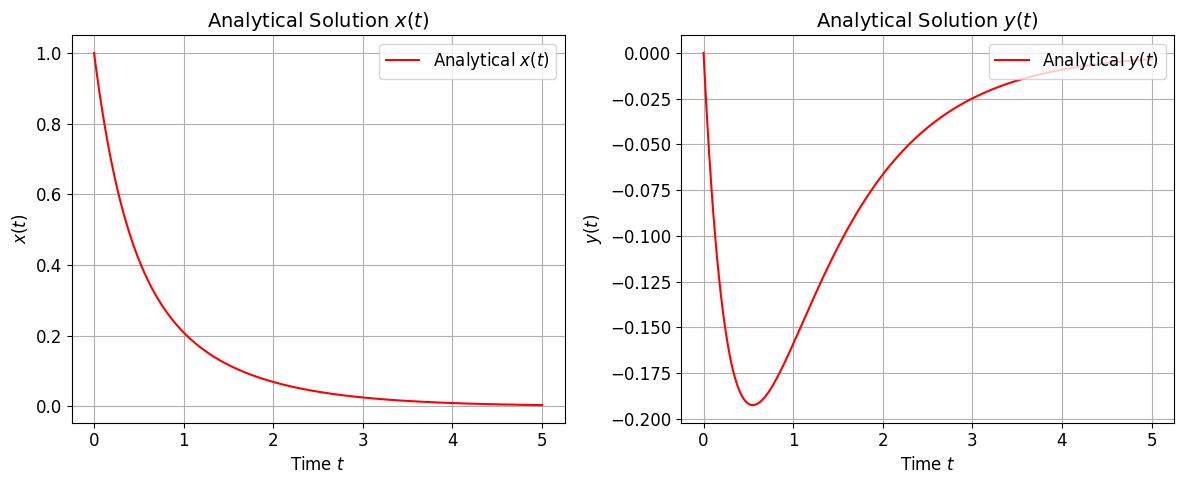

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Some plot settings
plt.close('all')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
# plt.rcParams['figure.dpi'] = 100 # useful, when run generate the plots in Spyder IDE

# Define the time domain
t = np.linspace(0, 5, 500)

# Define the analytical solutions for x(t) and y(t)
x_analytical = 0.5 * np.exp(-t) + 0.5 * np.exp(-3 * t)
y_analytical = -0.5 * np.exp(-t) + 0.5 * np.exp(-3 * t)

# Set up the plot with two subplots side by side
plt.figure(figsize=(12, 5))

# Plot x(t)
plt.subplot(1, 2, 1)
plt.plot(t, x_analytical, label=r'Analytical $x(t)$', color='red')
plt.title(r'Analytical Solution $x(t)$', fontsize=14)
plt.xlabel(r'Time $t$', fontsize=12)
plt.ylabel(r'$x(t)$', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12, loc='upper right')

# Plot y(t)
plt.subplot(1, 2, 2)
plt.plot(t, y_analytical, label=r'Analytical $y(t)$', color='red')
plt.title(r'Analytical Solution $y(t)$', fontsize=14)
plt.xlabel(r'Time $t$', fontsize=12)
plt.ylabel(r'$y(t)$', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12, loc='upper right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Epoch 0: Loss = [1.0787256]
Epoch 500: Loss = [0.00131859]
Epoch 1000: Loss = [0.00822986]
Epoch 1500: Loss = [3.5884095e-05]
Epoch 2000: Loss = [1.7405426e-05]
Epoch 2500: Loss = [9.16564e-06]
Epoch 3000: Loss = [6.097158e-06]
Epoch 3500: Loss = [1.7174601e-05]


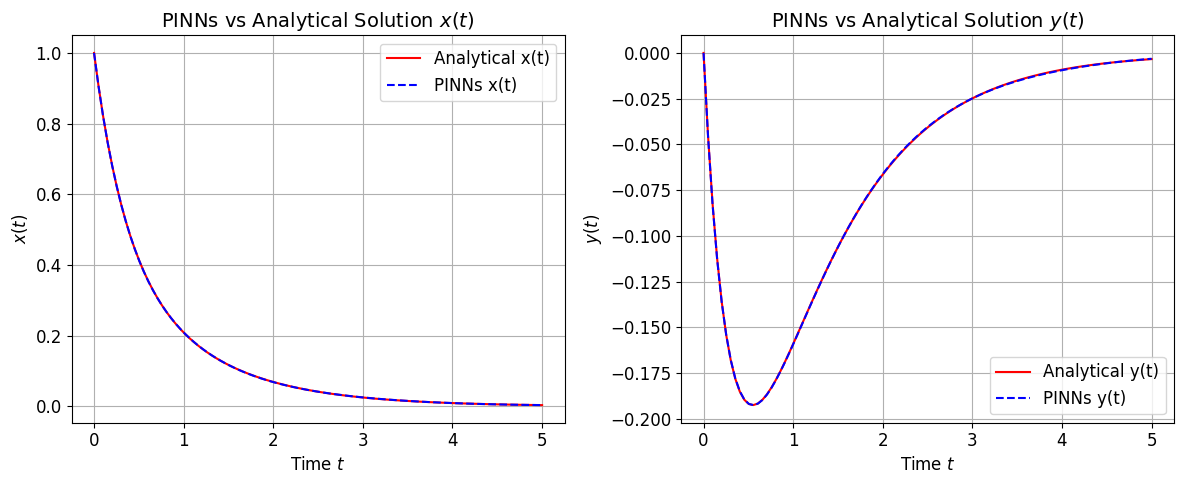

In [ ]:
import tensorflow as tf

# Define the NN
class PINN(tf.keras.Model):
  def __init__(self):
    super(PINN, self).__init__()
    self.dense1 = tf.keras.layers.Dense(64, activation='tanh')
    self.dense2 = tf.keras.layers.Dense(64, activation='tanh')
    self.dense3 = tf.keras.layers.Dense(2, activation=None) # Output layer: [x(t), y(t)]

  def call(self, t):
    t = self.dense1(t)
    t = self.dense2(t)
    return self.dense3(t)

# Define the Loss Function
def loss_fn(model, t):
    with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
        tape1.watch(t)
        tape2.watch(t)
        output = model(t)
        x = output[:, 0:1]
        y = output[:, 1:2]

        dx_dt = tape1.gradient(x, t)
        dy_dt = tape2.gradient(y, t)

        # Residuals from the ODEs
        res_x = dx_dt + 2 * x + y
        res_y = dy_dt + x + 2 * y

        # Initial condition losses
        init_loss_x = tf.square(x[0] - 1)
        init_loss_y = tf.square(y[0] - 0)

        # Total Loss
        loss = tf.reduce_mean(tf.square(res_x)) + tf.reduce_mean(tf.square(res_y)) + init_loss_x + init_loss_y
    return loss

# Define training function
def train(model, t, epochs, optimizer):
  for epoch in range(epochs):
    with tf.GradientTape() as tape:
      loss = loss_fn(model, t)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 500 == 0:
      print(f'Epoch {epoch}: Loss = {loss.numpy()}')

# Create the model and optimizer
model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training Domain
t = tf.convert_to_tensor(np.linspace(0, 5, 100)[:, None], dtype=tf.float32)

# Train the model
train(model, t, epochs=4000, optimizer=optimizer)

# Prediction using the trained model
t_test = np.linspace(0, 5, 100)[:, None]
x_pred, y_pred = model(t_test).numpy().T


# Analytical Solutions
x_true = 0.5 * np.exp(-t_test) + 0.5 * np.exp(-3 * t_test)
y_true = -0.5 * np.exp(-t_test) + 0.5 * np.exp(-3 * t_test)

# Set up the plot with two subplots side by side
plt.figure(figsize=(12, 5))

# Plot x(t)
plt.subplot(1, 2, 1)
plt.plot(t_test, x_true, label='Analytical x(t)', color='red')
plt.plot(t_test, x_pred, '--', label='PINNs x(t)', color='blue')
plt.title(r"PINNs vs Analytical Solution $x(t)$", fontsize=14)
plt.xlabel(r"Time $t$")
plt.ylabel(r"$x(t)$")
plt.grid(True)
plt.legend(fontsize=12, loc="upper right")

# Plot y(t)
plt.subplot(1, 2, 2)
plt.plot(t_test, y_true, label='Analytical y(t)', color='red')
plt.plot(t_test, y_pred, '--', label='PINNs y(t)', color='blue')
plt.title(r"PINNs vs Analytical Solution $y(t)$", fontsize=14)
plt.xlabel(r"Time $t$")
plt.ylabel(r"$y(t)$")
plt.grid(True)
plt.legend(fontsize=12, loc="lower right")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

